In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import random as rnd
import pandas_profiling
from  matplotlib.ticker import PercentFormatter

In [2]:
#WITHOUT USING THE GOOGLE API :D 
all_data = gpd.read_file("outputs/newvars_surveys.geojson")

# Creating new variables

In [3]:
#Dropping variables
all_data.drop(columns = ["geometry"],inplace = True)
all_data.drop(['index_right'], axis=1, inplace=True)
all_data = pd.DataFrame(all_data)

In [4]:
#cat and num variables
catvars = all_data.select_dtypes(include=['object','bool']).columns
numvars = all_data.select_dtypes(include=['int64','float64']).columns

In [5]:
#Dropping outliers 
merma_drop = all_data[all_data["cant_merma"] > 30].index
num_entregas_drop = all_data[all_data["num_entregas_fv"] >15 ].index
carga_drop = all_data[all_data["cant_carga"] > 350].index

In [6]:
#Dropping outliers
all_data.drop([merma_drop[0],merma_drop[1]],inplace = True)
all_data.drop([num_entregas_drop[0]],inplace = True)
all_data.drop([i for i in carga_drop], inplace = True)
all_data.drop([i for i in all_data[all_data["cant_sku"] > 40].index], inplace = True)

In [7]:
all_data.replace(0,np.nan,inplace = True)
all_data.replace("missing",np.nan,inplace = True)

In [8]:
all_data["vende_FyV"] = [1 if sum(i) > 0 else 0 for i in list(zip(all_data["venta_frutas"],all_data["venta_verduras"])) ]

CORRECTING MISSING DATA (0´s or NaN)

In [9]:
# rnd.uniform(-all_data["cant_merma"].describe()[2],all_data["cant_merma"].describe()[2])
def corec_carga(x):
    if x == 0:
        return mean_cant_carga + rnd.uniform(-data_cant_carga.describe()[2],data_cant_carga.describe()[2])
    else:
        return x

def corec_merma(x):
    if x == 0:
        return mean_cant_merma + rnd.uniform(-data_cant_merma.describe()[2],data_cant_merma.describe()[2])
    else:
        return x
def corec_sku(x):
    if x == 0:
        return mean_cant_sku + rnd.uniform(-data_cant_sku.describe()[2],data_cant_sku.describe()[2])
    else:
        return x

In [10]:
data_cant_carga = all_data[all_data["cant_carga"] > 0 ]["cant_carga"]
data_cant_merma = all_data[all_data["cant_merma"] > 0 ]["cant_merma"]
data_cant_sku = all_data[all_data["cant_sku"] > 0 ]["cant_sku"]

In [11]:
#CHANGING MISSING VALUES (0´s) to THE MEAN OF THE FEATURE PLUS A RANDOM VALUE
mean_cant_carga = data_cant_carga.mean()
mean_cant_merma = data_cant_merma.mean()
mean_cant_sku = data_cant_sku.mean()
all_data["cant_carga"] = all_data["cant_carga"].apply(corec_carga) 
all_data["cant_merma"] = all_data["cant_merma"].apply(corec_merma)
all_data["cant_sku"] = all_data["cant_sku"].apply(corec_sku) 

Zone Grouping

In [12]:
#Group by districts for zone

north_lima = ["CARABAYLLO","COMAS", "INDEPENDENCIA","LOS OLIVOS", "PUENTE PIEDRA","SAN MARTIN DE PORRES","ANCON",
              "SANTA ROSA"]
south_lima = ["CHORRILLOS","LURIN","PACHACAMAC","VILLA EL SALVADOR"]

east_lima = ["SAN JUAN DE LURIGANCHO","ATE","LA MOLINA"]

center_lima = ["SURQUILLO","SAN MIGUEL","BARRANCO",
               "SANTIAGO DE SURCO","SAN MIGUEL",
               "CHORRILLOS", "PUEBLO LIBRE",
               "LINCE","MAGDALENA DEL MAR"]

def zona(x):
    if x in north_lima:
        return "north_lima"
    elif x in south_lima:
        return "south_lima"
    
    elif x in east_lima:
        return "east_lima"
    elif x in center_lima:
        return "center_lima"

all_data["zone"] = all_data["distrito"].apply(zona)

# Visualizations and Distribution of Data

In [13]:
#Pandas profiling
pandas_profiling.ProfileReport(all_data)

/home/diegomatuk/anaconda3/lib/python3.7/site-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 2).')
  correlation_name=correlation_name, error=error


In [14]:
#See if there is important correlations between numeric variables
for cat in numvars:
    for cat2 in numvars:
        a = all_data[cat].corr(all_data[cat2])
        if (a > 0.6) and (a<1) and (cat!=cat2):
            print("{} vs {} :".format(cat,cat2) )
            print(a)

latitude vs gps_altitude :
0.6444852378908961
num_recojos_general vs num_recojos_fv :
0.8089795729895837
num_recojos_general vs num_viajes_lugar_principal :
0.6687925591703936
num_entregas_fv vs num_viajes_lugar_principal :
0.6877584518136448
num_recojos_fv vs num_recojos_general :
0.8089795729895837
num_recojos_fv vs num_viajes_lugar_principal :
0.7873097093429062
num_viajes_lugar_principal vs num_recojos_general :
0.6687925591703937
num_viajes_lugar_principal vs num_entregas_fv :
0.6877584518136448
num_viajes_lugar_principal vs num_recojos_fv :
0.7873097093429062
gps_altitude vs latitude :
0.6444852378908961
dist_2closest_mkt vs betweenness_centrality_avg :
0.6423941563100621
betweenness_centrality_avg vs dist_2closest_mkt :
0.6423941563100622


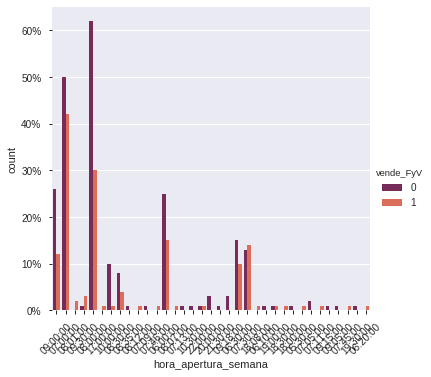

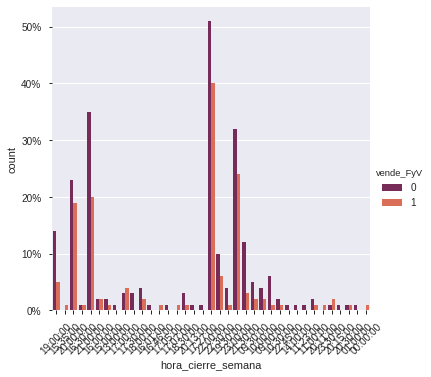

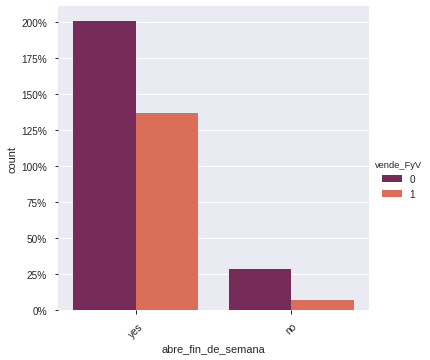

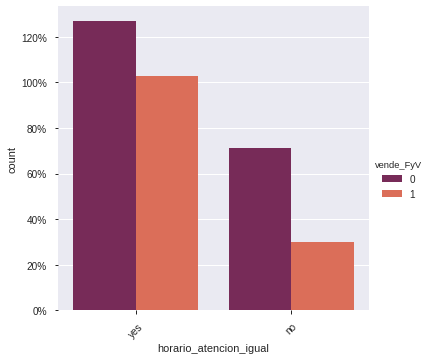

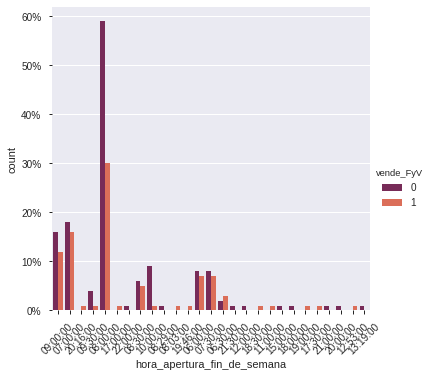

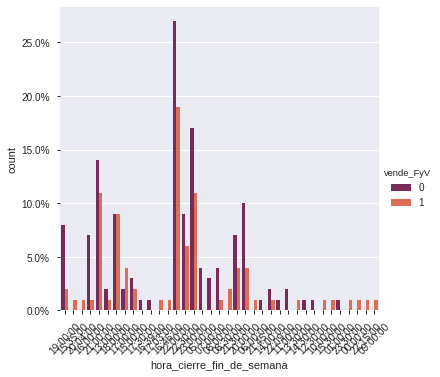

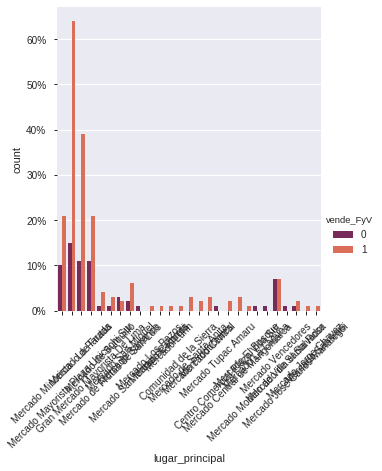

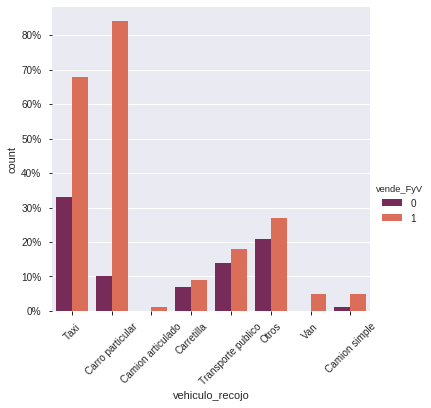

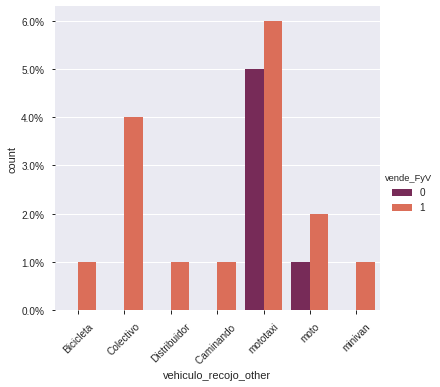

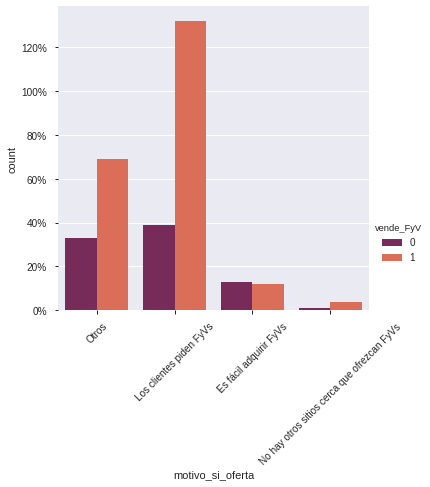

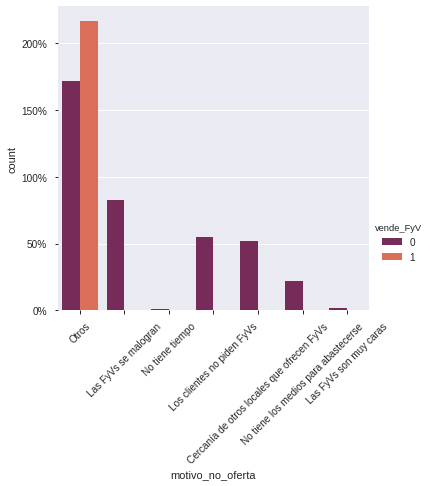

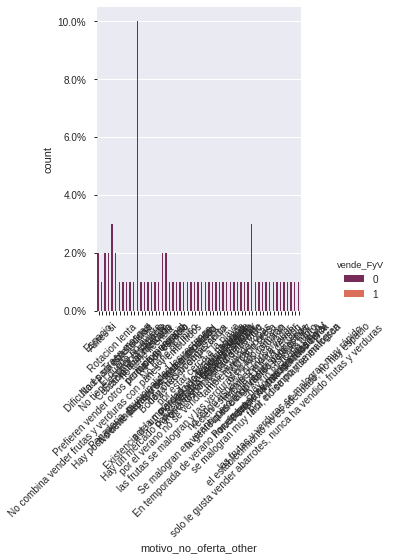

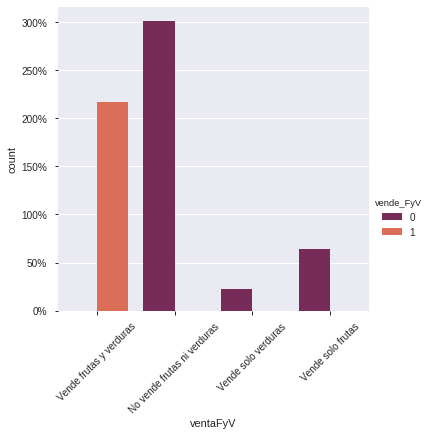

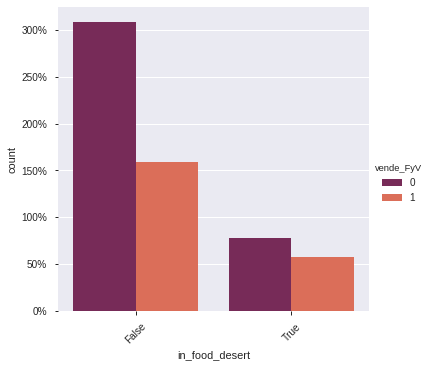

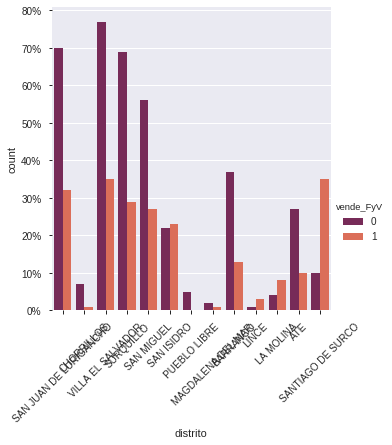

In [47]:
for cat in catvars:
    ax = sns.catplot(x=cat, hue="vende_FyV", kind="count",
                     data=all_data, palette="rocket",
                     )
    ax.set_xticklabels(rotation=45)
#     plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    for g in ax.axes.flat:
        g.yaxis.set_major_formatter(PercentFormatter())
    plt.show()